<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Laboratorio_VI_Solucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020


## Objetivos

*   Aplicar la técnica de data augmentation a un conjunto de imagenes.
*   Construir un clasificador de imagenes a partir de una red neuronal convolucional (CNN).
*   Construir un clasificador de imagenes utilizando la tecnica de transfer learning.
*   Construir una red neuronal de tipo autoencoder para la eliminación de ruido en imagenes.



## Taller
## Segundo Problema


Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.



### 1. Importando las librerias requeridas para el desarrollo del laboratorio


In [ ]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import joblib
from pandas_profiling import ProfileReport

from google.colab import files

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve

from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### 2. Perfilamiento y entendimiento de los datos


Primero se grafican las dos primeras imagenes de entrenamiento y test para ver que fue cargada correctamente.

In [ ]:
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
print(trainX.shape)
print(trainY.shape)

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(60000,)


Como se muestra en la [Doocumentación de keras](https://keras.io/api/datasets/fashion_mnist/), se encuentran 10 tipos de clases a analizar. Las clases son:

| Label | Description   |
|------|------|
|0	|T-shirt/top|
|1	|Trouser|
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag|
|9	|Ankle boot|

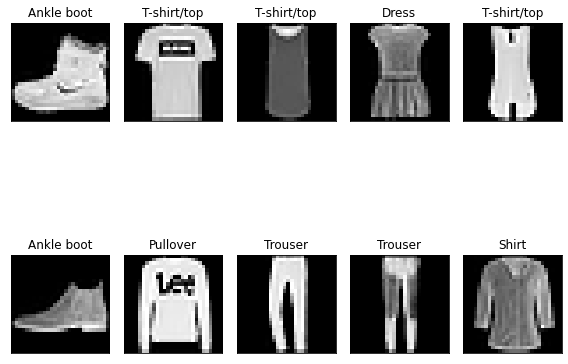

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n = 5
fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(8, 8))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(trainX[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(title=class_names[trainY[i]])

    # display reconstruction
    ax = plt.subplot(2, n, i + 6)
    plt.imshow(testX[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(title=class_names[testY[i]])

plt.tight_layout()
plt.show()

### 3. Preparación de datos

Para la preparación de los datos, se realiza un redimensionamiento de los datos. Es decir, vamos a 'aplanar' las imagenes para poder construir la capa de entrada. Además, para facilidad del modelo, vamos a normalizar la entrada.

In [ ]:
X_train , X_test = np.reshape(trainX,(trainX.shape[0],trainX.shape[1]*trainX.shape[2]))/255 , np.reshape(testX,(testX.shape[0],testX.shape[1]*testX.shape[2]))/255

Y_train, Y_test = np.array(trainY,dtype=np.float32), np.array(testY,dtype=np.float32) 

print("Dimensiones de X",X_train.shape,"Dimensiones de Y",Y_train.shape,sep="\n")

Dimensiones de X
(60000, 784)
Dimensiones de Y
(60000,)


### 4. Modelamiento

#### Perceptron Multicapa

Para obtener el mejor modelo, se realizan 30 iteraciones aleatorias entre los parámetros para obtener un buen modelo para predecir. Entre los hiperparámetros a buscar se realizará el número de capas, el número de neuronas en cada capa, la activación de la capa oculta, y el porcentaje de Dropout. 

In [ ]:
def entrenarClasificador(nn1 = 512, nn2 = 100, nn3 = 32, n_layers= 2, dropout = 0.1, 
                         activacion_oculta = 'relu', input = 784):
    clf = Sequential(name='Mi_Red')
    nn = [nn1,nn2,nn3]
    clf.add(Input(shape=(input,),name='Capa_Entrada'))

    for i in range(n_layers):
        clf.add(Dense(nn[i], activation=activacion_oculta, name = 'Capa_Oculta_{0}__{1}'.format(i,nn2)))
    
        clf.add(Dropout(dropout,name='Dropout__{0}__{1}'.format(i,dropout)))
    
    clf.add(Dense(len(class_names), activation='sigmoid', name= 'Capa_Salida'))
    clf.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenarClasificador, epochs=25, batch_size=100, verbose=0,shuffle = True)


In [ ]:
param_grid = dict(nn1 = [512, 256, 128],
                  nn2 = [256, 128, 64],
                  nn3 = [128, 64, 32],
                  n_layers = [1,2,3],
                  dropout = [0.1,0.25,0.5],
                  activacion_oculta = ['relu','sigmoid','tanh']
                  )

grid = RandomizedSearchCV(modelCV,param_grid,scoring='accuracy',verbose=20,n_jobs=-1,cv = 5,n_iter=30,random_state=20)

grid.fit(X_train,Y_train)

best_classifier = grid.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.7min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 

In [ ]:
best_classifier.model.save('best_classifier.h5')

#Esto solo sirve si estoy en Google Collab
files.download('best_classifier.h5') 

print(best_classifier.model.summary())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "Mi_Red"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta_0__128 (Dense)   (None, 256)               200960    
_________________________________________________________________
Dropout__0__0.1 (Dropout)    (None, 256)               0         
_________________________________________________________________
Capa_Salida (Dense)          (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


#### Undercompleted Autoencoder

Primero, se evalua un autoencoder bajo la arquitectura de un Undercomplete para reducción de la dimensionalidad. Para ello, vamos a construir un autoencoder con 512 neruonas.

In [ ]:
autoencoder = Sequential(name='Udercomplete_Autoencoder')

#Input image
autoencoder.add(Input(shape=(784,),name='Capa_Entrada'))
autoencoder.add(Dense(units=512, activation='relu',name='encoded-1'))
autoencoder.add(Dense(units=784, activation='sigmoid',name='decoded-1'))

# compiling the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
# Fitting the data to the autoencoder 
autoencoder.fit(X_train, X_train, epochs=20, batch_size=10)
X_rec = autoencoder.predict(X_train)


Epoch 1/20
6000/6000 [==============================] - 31s 5ms/step - loss: 0.2747 - accuracy: 0.0523 - mse: 0.0105
Epoch 2/20
6000/6000 [==============================] - 32s 5ms/step - loss: 0.2567 - accuracy: 0.1096 - mse: 0.0045
Epoch 3/20
6000/6000 [==============================] - 32s 5ms/step - loss: 0.2538 - accuracy: 0.1477 - mse: 0.0036
Epoch 4/20
6000/6000 [==============================] - 31s 5ms/step - loss: 0.2525 - accuracy: 0.1677 - mse: 0.0032
Epoch 5/20
6000/6000 [==============================] - 32s 5ms/step - loss: 0.2517 - accuracy: 0.1840 - mse: 0.0030
Epoch 6/20
6000/6000 [==============================] - 32s 5ms/step - loss: 0.2513 - accuracy: 0.1917 - mse: 0.0028
Epoch 7/20
6000/6000 [==============================] - 33s 6ms/step - loss: 0.2510 - accuracy: 0.1963 - mse: 0.0027
Epoch 8/20
6000/6000 [==============================] - 33s 6ms/step - loss: 0.2507 - accuracy: 0.2028 - mse: 0.0027
Epoch 9/20
6000/6000 [==============================] - 32s 5ms/

In [ ]:
encoder =Model(autoencoder.layers[0].input,autoencoder.layers[-1].input,name='Udercomplete_Encoder')
for layer in encoder.layers:
  layer.trainable = False
  
X_enc = encoder.predict(X_train)
encoder.summary()

Model: "Udercomplete_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Entrada (InputLayer)    [(None, 784)]             0         
_________________________________________________________________
encoded-1 (Dense)            (None, 512)               401920    
Total params: 401,920
Trainable params: 0
Non-trainable params: 401,920
_________________________________________________________________


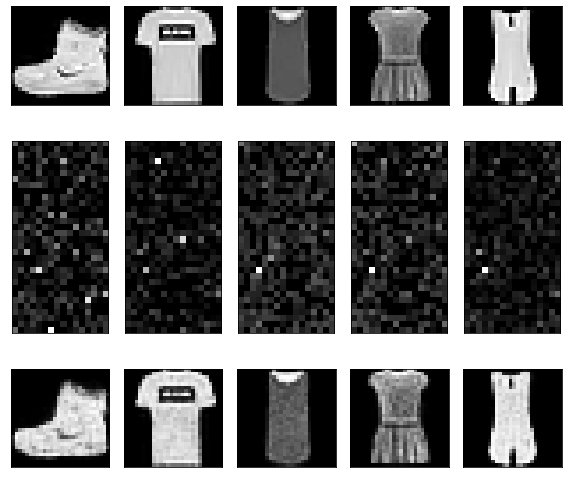

In [ ]:
n = 5
fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(8, 8))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_train[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    ax = plt.subplot(3, n, i + n+1)
    plt.imshow(X_enc[i].reshape(32, 16),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstructed
    ax = plt.subplot(3, n, i + 2*n+1)
    plt.imshow(X_rec[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
param_grid = dict(input = [X_enc.shape[1]],
                  nn1 = [512, 256, 128],
                  nn2 = [256, 128, 64],
                  nn3 = [128, 64, 32],
                  n_layers = [1,2,3],
                  dropout = [0.1,0.25,0.5],
                  activacion_oculta = ['relu','sigmoid','tanh']
                  )

grid = RandomizedSearchCV(modelCV,param_grid,scoring='accuracy',verbose=20,n_jobs=-1,cv = 5,n_iter=30,random_state=20)

grid.fit(X_enc,Y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  9.5min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused b

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4bf9212b38>,
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'activacion_oculta': ['relu', 'sigmoid',
                                                              'tanh'],
                                        'dropout': [0.1, 0.25, 0.5],
                                        'input': [512], 'n_layers': [1, 2, 3],
                                        'nn1': [512, 256, 128],
                                        'nn2': [256, 128, 64],
                                        'nn3': [128, 64, 32]},
                   pre_dispatch='2*n_jobs', random_state=20, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=20)

In [ ]:
undercomplete_classifier = Sequential()
undercomplete_classifier.add(encoder)
undercomplete_classifier.add(grid.best_estimator_.model)

undercomplete_classifier.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Udercomplete_Encoder (Model) (None, 512)               401920    
_________________________________________________________________
Mi_Red (Sequential)          (None, 10)                396554    
Total params: 798,474
Trainable params: 396,554
Non-trainable params: 401,920
_________________________________________________________________


#### Denoising Autoencoder

Para obtener el mejor modelo, se realizan 30 iteraciones aleatorias entre los parámetros para obtener un buen modelo para predecir. Entre los hiperparámetros a buscar se realizará el número de capas, el número de neuronas en cada capa, la activación de la capa oculta, y el porcentaje de Dropout. 

In [ ]:
X_n,_ = train_test_split(X_train,train_size=0.1)

X_noisy = X_n + np.random.normal(loc=0.0, scale=0.5, size=X_n.shape)
X_noisy = np.clip(X_noisy, 0., 1.)


In [ ]:
autoencoder = Sequential(name='Denoising_Autoencoder')

#Input image
autoencoder.add(Input(shape=(784,),name='Capa_Entrada'))
autoencoder.add(Dense(units=512, activation='relu',name='encoded-1'))
autoencoder.add(Dense(units=784, activation='sigmoid',name='decoded-1'))

# compiling the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
# Fitting the data to the autoencoder 
autoencoder.fit(X_noisy, X_n, epochs=20, batch_size=10)

X_rec = autoencoder.predict(X_n)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.3543 - accuracy: 0.0090 - mse: 0.0383
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.3120 - accuracy: 0.0120 - mse: 0.0240
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.3007 - accuracy: 0.0142 - mse: 0.0201
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2937 - accuracy: 0.0167 - mse: 0.0177
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2887 - accuracy: 0.0208 - mse: 0.0160
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2849 - accuracy: 0.0267 - mse: 0.0148
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2818 - accuracy: 0.0272 - mse: 0.0138
Epoch 8/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2797 - accuracy: 0.0302 - mse: 0.0131
Epoch 9/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2775 - accur

In [ ]:
encoder =Model(autoencoder.layers[0].input,autoencoder.layers[-1].input,name='Denoising_Encoder')
for layer in encoder.layers:
  layer.trainable = False

X_enc = encoder.predict(X_n)
encoder.summary()

Model: "Denoising_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Entrada (InputLayer)    [(None, 784)]             0         
_________________________________________________________________
encoded-1 (Dense)            (None, 512)               401920    
Total params: 401,920
Trainable params: 0
Non-trainable params: 401,920
_________________________________________________________________


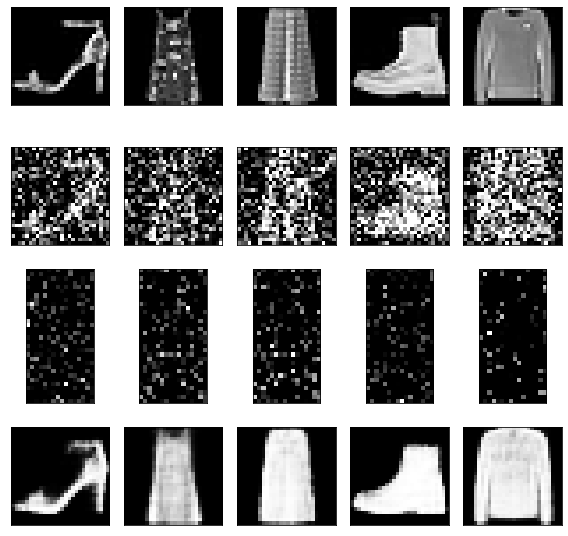

In [ ]:
n = 5
fig, axes = plt.subplots(nrows=4, ncols=n, figsize=(8, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i+1)
    plt.imshow(X_n[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display noisy
    ax = plt.subplot(4, n, i + n+1)
    plt.imshow(X_noisy[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    ax = plt.subplot(4, n, i + 2*n+1)
    plt.imshow(X_enc[i].reshape(32, 16),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display recosntructed
    ax = plt.subplot(4, n, i + 3*n+1)
    plt.imshow(X_rec[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
param_grid = dict(input = [X_enc.shape[1]],
                  nn1 = [512, 256, 128],
                  nn2 = [256, 128, 64],
                  nn3 = [128, 64, 32],
                  n_layers = [1,2,3],
                  dropout = [0.1,0.25,0.5],
                  activacion_oculta = ['relu','sigmoid','tanh']
                  )

grid = RandomizedSearchCV(modelCV,param_grid,scoring='accuracy',verbose=20,n_jobs=-1,cv = 5,n_iter=30,random_state=20)

X_enc = encoder.predict(X_train)
grid.fit(X_enc,Y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4bf9212b38>,
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'activacion_oculta': ['relu', 'sigmoid',
                                                              'tanh'],
                                        'dropout': [0.1, 0.25, 0.5],
                                        'input': [512], 'n_layers': [1, 2, 3],
                                        'nn1': [512, 256, 128],
                                        'nn2': [256, 128, 64],
                                        'nn3': [128, 64, 32]},
                   pre_dispatch='2*n_jobs', random_state=20, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=20)

In [ ]:
denoising_classifier = Sequential()
denoising_classifier.add(encoder)
denoising_classifier.add(grid.best_estimator_.model)

denoising_classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Denoising_Encoder (Model)    (None, 512)               401920    
_________________________________________________________________
Mi_Red (Sequential)          (None, 10)                396554    
Total params: 798,474
Trainable params: 396,554
Non-trainable params: 401,920
_________________________________________________________________


### **5. Predicción**

Para evaluar las predicciones se van a construir los 3 diferentes modelos propuestos a lso cuales se van a nombrar:

1. **Modelo completo:** Se obtienen las imágenes originales redimensionadas a 2 dimensiones, y se clasifica con el mejor clasificador hallado.
2. **Modelo reducido:** Con las imágenes originales se realiza la mejor reducción de dimensionalidad con el undercomplete autoencoder y se entrena con el mejor clasificador hallado.
3. **Modelo reducido con Ruido:** Con las imágenes originales se realiza la mejor reducción de dimensionalidad con el denoising autoencoder y se entrena con el mejor clasificador hallado.

In [ ]:
y_pred1 = best_classifier.predict(X_test)
y_pred1

array([9., 2., 1., ..., 8., 1., 5.], dtype=float32)

In [ ]:
y_pred3 = undercomplete_classifier.predict(X_test).argmax(axis=-1)
y_pred3

array([9, 2, 1, ..., 8, 1, 5])

In [ ]:
y_pred2 = denoising_classifier.predict(X_test).argmax(axis=-1)
y_pred2

array([9, 2, 1, ..., 8, 1, 5])

### **6. Validación**

In [ ]:
print('Reporte para el Modelo completo')
print(classification_report(Y_test, y_pred1, target_names=class_names))
print('Reporte para el Modelo reducido')
print(classification_report(Y_test, y_pred2, target_names=class_names))
print('Reporte para el Modelo reducido con Ruido')
print(classification_report(Y_test, y_pred3, target_names=class_names))

Reporte para el Modelo completo
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.78      0.83      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.82      0.78      0.80      1000
       Dress       0.89      0.90      0.89      1000
        Coat       0.78      0.86      0.82      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.70      0.75      0.72      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Reporte para el Modelo reducido
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.83      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover  

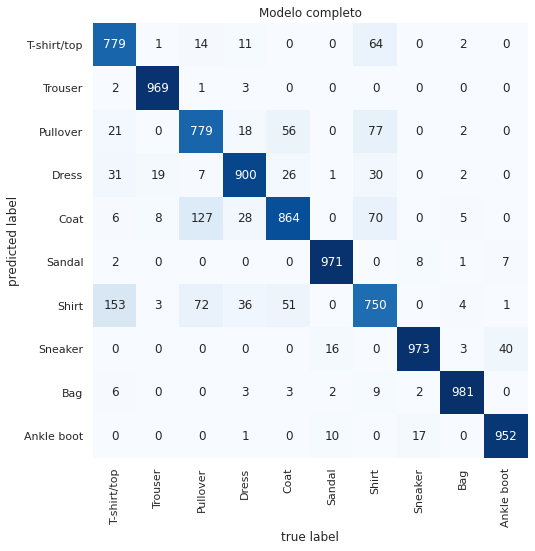

Text(54.260000000000005, 0.5, 'predicted label')

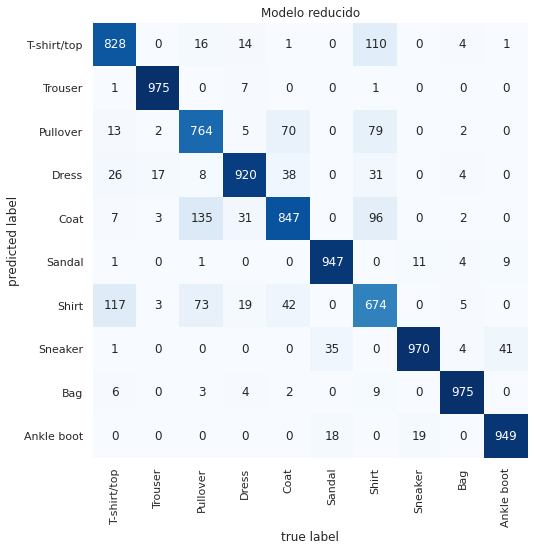

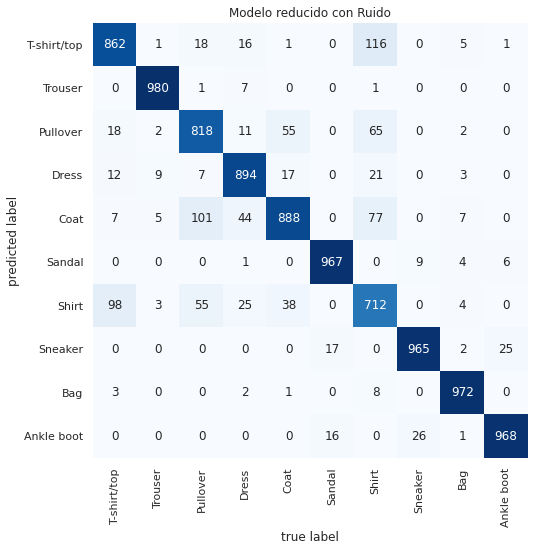

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred1)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Modelo completo')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred2)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Modelo reducido')
plt.xlabel('true label')
plt.ylabel('predicted label')

plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred3)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Modelo reducido con Ruido')
plt.xlabel('true label')
plt.ylabel('predicted label')